# Prediction model using topic distribution

Most topics found in reviews were related to procduct features (scent, packaging and price) or skin concerns (aging and acne). To figure out product features and skin concerns determine customers' satisfaction (review rating), I tried to build prediction models using topic distribution in different reviews.

In [10]:
from __future__ import division
import warnings;warnings.filterwarnings(action='ignore')
%run ./topics.py
bt = BellaTopics()
import numpy as np
ZERO_SUBSTITUTE = 0.0000001

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [11]:
cd /Users/Nan/insight/bella/

/Users/Nan/insight/bella


In [13]:
fp = './bella/bellaflask/tmp/nmf_vectors.df.pk'
with open(fp,'rb') as f:
    nmf_vector = pickle.load(f)
fp = './bella/bellaflask/tmp/lda_vectors.df.pk'
with open(fp,'rb') as f:
    lda_vector = pickle.load(f)

In [14]:
#log transformation to avoid collinearity in compositional data
X, Y = lda_vector.iloc[:,-9:], lda_vector.iloc[:, 3]
#replace zero to a extreme small number to avoid error in log
X_log = X.replace(0, ZERO_SUBSTITUTE)
X_log = np.log(X_log)
g = 4
b = 4
Y_g = map(lambda v: v > g, Y)
Y_b = map(lambda v: v < b, Y)


## Split train test sets

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_log, Y_g, 
                                    test_size=0.3, 
                                    random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Models and evaluation

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
#from scikitplot.estimators import plot_learning_curve

def model_learningcurve(estimator, params, X, y, out_fp,
                        ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Classification plot of model
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #y_type is the way categorize ratings
    y_type, modelname = params
    plot_label = '%s.%s_classifier' % (y_type, modelname)
    title = 'Learning Curve(%s)' % (plot_label)
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    sns.set();sns.set_context({"figure.figsize": (6,6)});sns.set_context('talk')
    sns.set_style('white',{'font.family':'sans-serif',
                         'font.sans-serif':['Helvetica']})
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig('%s/%s_learning_curve.png' % (out_fp, plot_label), bbox_inches='tight')
    return plt

/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2019-01-31 04:12:26.101836. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


### LDA topics

<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

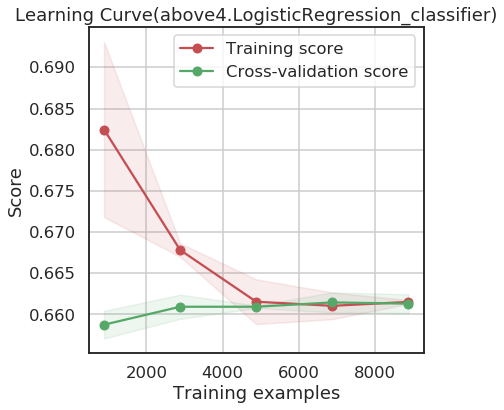

In [9]:
fig_fp = './bella/bellamodel/results'
#logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='ovr').fit(X_train_scaled, y_train)
model_learningcurve(lr, ('above4', 'LogisticRegression'), 
                    X_train_scaled, y_train,
                    fig_fp)

In [24]:
Cs=[0.5, 0.6, 0.7, 0.8]
score = 'f1'
grid_values = {'C': Cs}
lr = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='ovr')
grid_lr = GridSearchCV(lr, param_grid=grid_values, scoring=score)
grid_lr.fit(X_train_scaled, y_train)
best_model = grid_lr.best_estimator_
print("Best Model's Params: ", grid_lr.best_params_)
print("Best F1 Score: ", grid_lr.best_score_)

("Best Model's Params: ", {'C': 0.7})
('Best F1 Score: ', 0.7850677435376067)


<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

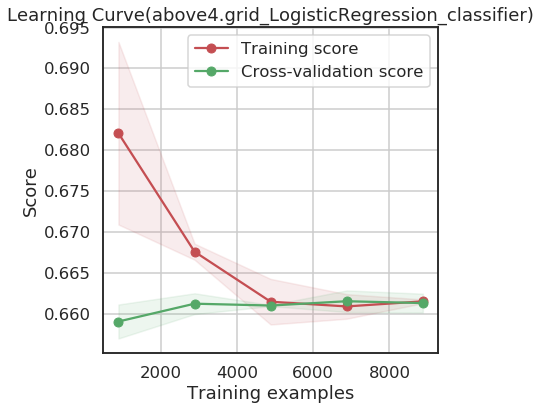

In [25]:
model_learningcurve(best_model, ('above4', 'grid_LogisticRegression'), 
                    X_train_scaled, y_train,
                    fig_fp)

In [31]:
#SVM
from sklearn.svm import SVC
gammas=[0.04, 0.05, 0.06]
score = 'f1'
svm = SVC(kernel='rbf')
#grid_values = {'gamma': gammas, 'kernel':('linear', 'rbf')}
grid_values = {'gamma': gammas}
grid_svm = GridSearchCV(svm, param_grid=grid_values, scoring=score)
grid_svm.fit(X_train_scaled, y_train)
best_model = grid_svm.best_estimator_
print("Best Model's Params: ", grid_svm.best_params_)
print("Best Log F1 Score: ", grid_svm.best_score_)

("Best Model's Params: ", {'gamma': 0.05})
('Best Log F1 Score: ', 0.7991892636439494)


<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

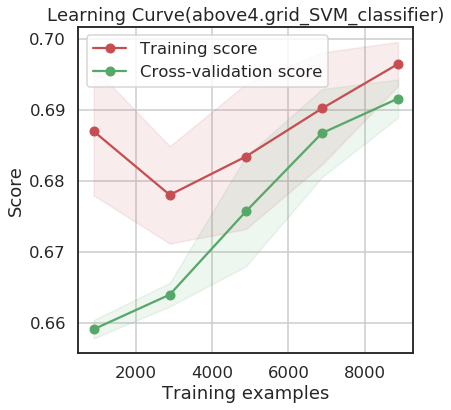

In [32]:
model_learningcurve(best_model, ('above4', 'grid_SVM'), 
                    X_train_scaled, y_train,
                    fig_fp)

In [35]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#grid_values = { 
#    'n_estimators': [50, 100, 200],
#    'max_features': ['sqrt', 'log2'],
#    'max_depth':[3, 4, 5]
#}
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             oob_score=True,
                             random_state=0)
grid_rf = GridSearchCV(rf, param_grid=grid_values, scoring=score)
grid_rf.fit(X_train_scaled, y_train)
best_model = grid_rf.best_estimator_
print("Best Model's Params: ", grid_rf.best_params_)
print("Best Log F1 Score: ", grid_rf.best_score_)

("Best Model's Params: ", {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 4})
('Best Log F1 Score: ', 0.8068942355577067)


<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

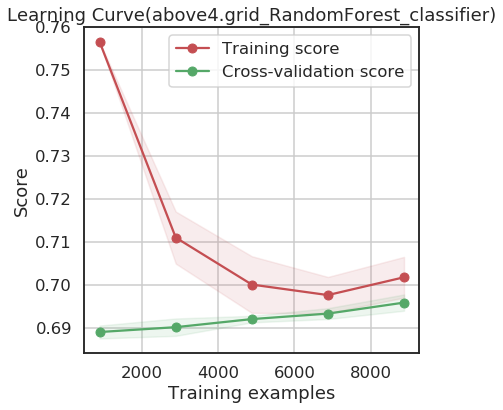

In [36]:
model_learningcurve(best_model, ('above4', 'grid_RandomForest'), 
                    X_train_scaled, y_train,
                    fig_fp)

In [53]:
#distributed gradient boost
from sklearn.ensemble import GradientBoostingClassifier
grid_values = { 
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.06, 0.07],
    'max_depth':[1, 2]
}
gb = GradientBoostingClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
grid_GB = GridSearchCV(gb, param_grid=grid_values, scoring=score)
grid_GB.fit(X_train_scaled, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100], 'learning_rate': [0.05, 0.06, 0.07], 'max_depth': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

("Best Model's Params: ", {'n_estimators': 100, 'learning_rate': 0.06, 'max_depth': 1})
('Best F1 Score: ', 0.8059536370461612)


<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

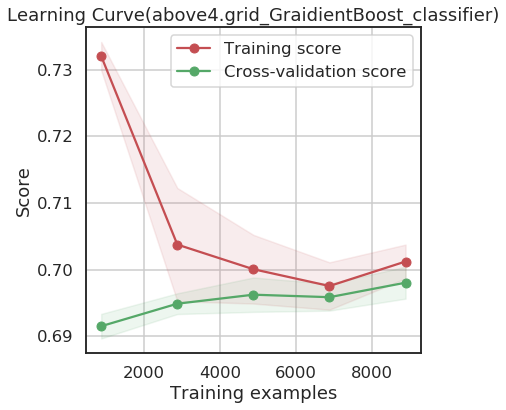

In [54]:
best_model = grid_GB.best_estimator_
print("Best Model's Params: ", grid_GB.best_params_)
print("Best F1 Score: ", grid_GB.best_score_)
model_learningcurve(best_model, ('above4', 'grid_GraidientBoost'), 
                    X_train_scaled, y_train,
                    fig_fp)

### NMF topics

In [81]:
#log transformation to avoid collinearity in compositional data
X, Y = lda_vector.iloc[:,-9:], lda_vector['r_star']
#replace zero to a extreme small number to avoid error in log
X_log = X.replace(0, ZERO_SUBSTITUTE)
X_log = np.log(X_log)
g = 4
b = 4
Y_g = map(lambda v: v > g, Y)
Y_b = map(lambda v: v < b, Y)

In [82]:
#split train test sets
X_train, X_test, y_train, y_test = train_test_split(X_log, Y_g, 
                                    test_size=0.3, 
                                    random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
#nmf logistic regression
Cs=[0.1, 0.2, 0.3]
score = 'f1'
grid_values = {'C': Cs}
lr = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='ovr')
grid_lr = GridSearchCV(lr, param_grid=grid_values, scoring=score)
grid_lr.fit(X_train_scaled, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 0.2, 0.3]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1', verbose=0)

("Best Model's Params: ", {'C': 0.2})
('Best F1 Score: ', 0.7991609103815556)


<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

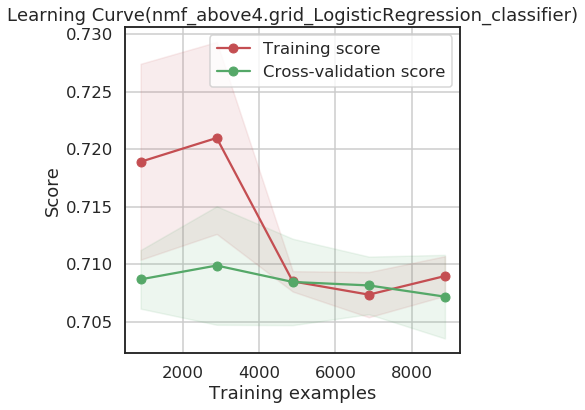

In [62]:
best_model = grid_lr.best_estimator_
print("Best Model's Params: ", grid_lr.best_params_)
print("Best F1 Score: ", grid_lr.best_score_)
model_learningcurve(best_model, ('nmf_above4', 'grid_LogisticRegression'), 
                    X_train_scaled, y_train,
                    fig_fp)

In [67]:
#NMF SVM
from sklearn.svm import SVC
gammas=[0.03, 0.04, 0.05]
score = 'f1'
svm = SVC(kernel='rbf')
grid_values = {'gamma': gammas, 'kernel':('linear', 'rbf')}
#grid_values = {'gamma': gammas}
grid_svm = GridSearchCV(svm, param_grid=grid_values, scoring=score)
grid_svm.fit(X_train_scaled, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf'), 'gamma': [0.03, 0.04, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

("Best Model's Params: ", {'kernel': 'rbf', 'gamma': 0.04})
('Best Log F1 Score: ', 0.8073854141551009)


<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

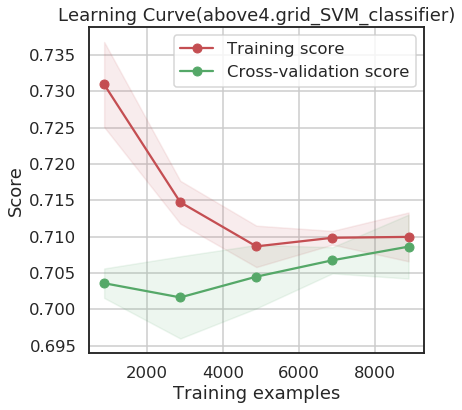

In [68]:
best_model = grid_svm.best_estimator_
print("Best Model's Params: ", grid_svm.best_params_)
print("Best Log F1 Score: ", grid_svm.best_score_)
model_learningcurve(best_model, ('above4', 'grid_SVM'), 
                    X_train_scaled, y_train,
                    fig_fp)

In [83]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
grid_values = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth':[4, 5, 6]
}
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             oob_score=True,
                             random_state=0)
grid_rf = GridSearchCV(rf, param_grid=grid_values, scoring=score)
grid_rf.fit(X_train_scaled, y_train)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300], 'max_features': ['sqrt', 'log2'], 'max_depth': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

("Best Model's Params: ", {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 4})
('Best Log F1 Score: ', 0.8068942355577067)


<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

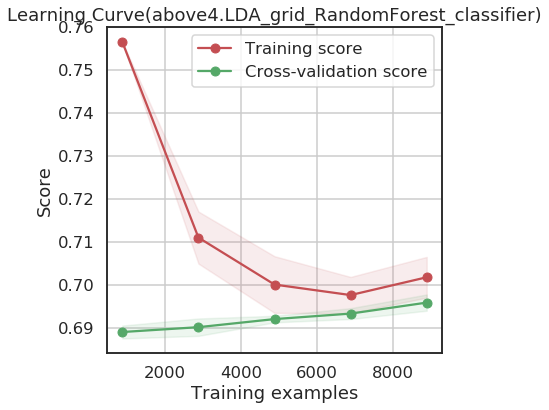

In [88]:
best_model = grid_rf.best_estimator_
print("Best Model's Params: ", grid_rf.best_params_)
print("Best Log F1 Score: ", grid_rf.best_score_)
model_learningcurve(best_model, ('above4', 'LDA_grid_RandomForest'), 
                    X_train_scaled, y_train,
                    fig_fp)

In [140]:
#distributed gradient boost
from sklearn.ensemble import GradientBoostingClassifier
grid_values = { 
    'n_estimators': [40, 50, 60],
    'learning_rate': [0.04, 0.05, 0.06],
    'max_depth':[1, 2, 3]
}
gb = GradientBoostingClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
grid_GB = GridSearchCV(gb, param_grid=grid_values, scoring='precision')
grid_GB.fit(X_train_scaled, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [40, 50, 60], 'learning_rate': [0.04, 0.05, 0.06], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

("Best Model's Params: ", {'n_estimators': 60, 'learning_rate': 0.06, 'max_depth': 3})
('Best F1 Score: ', 0.7198451024934206)


<module 'matplotlib.pyplot' from '/Users/Nan/anaconda2/envs/bella/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

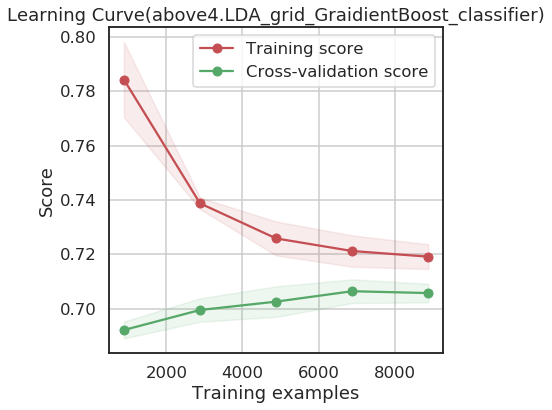

In [141]:
best_model = grid_GB.best_estimator_
print("Best Model's Params: ", grid_GB.best_params_)
print("Best F1 Score: ", grid_GB.best_score_)
model_learningcurve(best_model, ('above4', 'LDA_grid_GraidientBoost'), 
                    X_train_scaled, y_train,
                    fig_fp)

In [91]:
fp = './bella/bellaflask/tmp/lda_GB.model.pk'
with open(fp,'wb') as f:
   pickle.dump(best_model, f)

In [92]:
best_model.feature_importances_

array([0.        , 0.12672646, 0.06156695, 0.03600467, 0.29209812,
       0.17375965, 0.03200098, 0.27784317])

In [143]:
fp = './bella/bellaflask/tmp/lda_topic_model.pk'
with open(fp,'rb') as f:
    lda = pickle.load(f)
fp = './bella/bellaflask/tmp/cnt_vectorizer.pk'
with open(fp,'rb') as f:
    cnt_vectorizer = pickle.load(f)
#5 star
test_review = 'This product is my holy grail. '\
               'At night, I wash my face, use a toner, '\
                'let the toner dry, and then use this on trouble spots '\
              '(and the moisturize). This works wonders on my acne-prone,'\
               'combination skin without drying me out! '\
                'It is very gentle and a little goes a long way.'
#1 star
test_review = 'My skin is combo, more towards oily in summer (now). Ive given a good 2 weeks trial for this set but I can safely say that it did nothing for me but to make me feel more oily and sticky that I usually do.  I can see this set working for the dry skin gals out there but for me, its a no go.'
new_vec = cnt_vectorizer.transform([test_review])
topic_vec = lda.transform(new_vec)


In [144]:
best_model.predict(topic_vec)


array([ True])

In [145]:
best_model.predict(topic_vec)


array([ True])

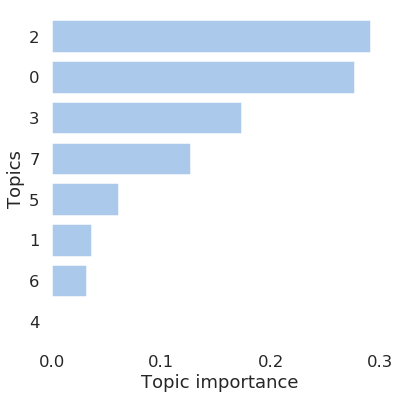

In [125]:
importances = best_model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in best_model.estimators_],axis=0)
#indices = np.argsort(importances)[::-1]
feature_importances = pd.DataFrame({'feature': np.argsort(importances)[::-1], 
                                            'importance':importances})
feature_importances = feature_importances.sort_values(by='importance', 
                                                              ascending=False)
topic_order = feature_importances.feature
# Plot the feature importances of the forest
# Initialize the matplotlib figure
plt.figure()
        
sns.set_color_codes('pastel')
ax = sns.barplot(x='importance', y='feature', data=feature_importances,
                    label='importance', color="b", orient='h', order=topic_order)
ax.set( ylabel='Topics',
               xlabel='Topic importance')
sns.despine(left=True, bottom=True)

In [108]:
best_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.04, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Conlusion 
All the learning curves of different models failed to converge. Topic distributions only cannot predict review ratings. The distribution of ratings of reviews with different dominant topics (Business_topicModeling.ipynb) did not vary a lot. We can probably improve prediction accuracy with sentiment. But it is too obvious and does not serve our purpose (find out customers' preference). Therefore, I added a business analyst function to Bella, using dominant topic and customer features (e.g. skin type, age) to find out main concerns in different customer subgroups.